# CS4035 - Cyber Data Analytics
## Lab 2 

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID : 5074274

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

#### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import collections
import math
import itertools
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})
%config InlineBackend.figure_format = 'retina'
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 10)})

#### Reading in the data.


In [2]:
#Please provide the correct path for these datasets below. 
data = pd.read_csv("BATADAL_dataset03.csv")
dataA = pd.read_csv("BATADAL_dataset04.csv")
# To remove the annoying ' ' before column names in the validation set
dataA.columns = ['DATETIME', 'L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6',
       'L_T7', 'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3',
       'F_PU4', 'S_PU4', 'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7',
       'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10',
       'F_PU11', 'S_PU11', 'F_V2', 'S_V2', 'P_J280', 'P_J269', 'P_J300',
       'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307',
       'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG']
# Converting the labels of dataA to 1s and 0s
dataA['ATT_FLAG'] = dataA['ATT_FLAG'].apply(lambda x: 0 if x < 1 else 1)
#Converting DATETIME to a timestamp format and setting the index.
data["DATETIME"]= pd.to_datetime(data["DATETIME"])
data = data.set_index('DATETIME')
dataA["DATETIME"]= pd.to_datetime(dataA["DATETIME"])
dataA = dataA.set_index('DATETIME')
testdata=pd.read_csv("BATADAL_test_dataset.csv")
#Creating year, month, weekday_name and hour variables for each data point.
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Weekday Name'] = data.index.weekday_name
data['Hour'] = data.index.hour
test_df = pd.read_csv('BATADAL_test_dataset.csv')
y_test = test_df[['Labels']].values
test_df = test_df.drop(['Labels'], axis=1)

## 1. Familiarization task – 1 A4

### 1a. Plot visualizations 

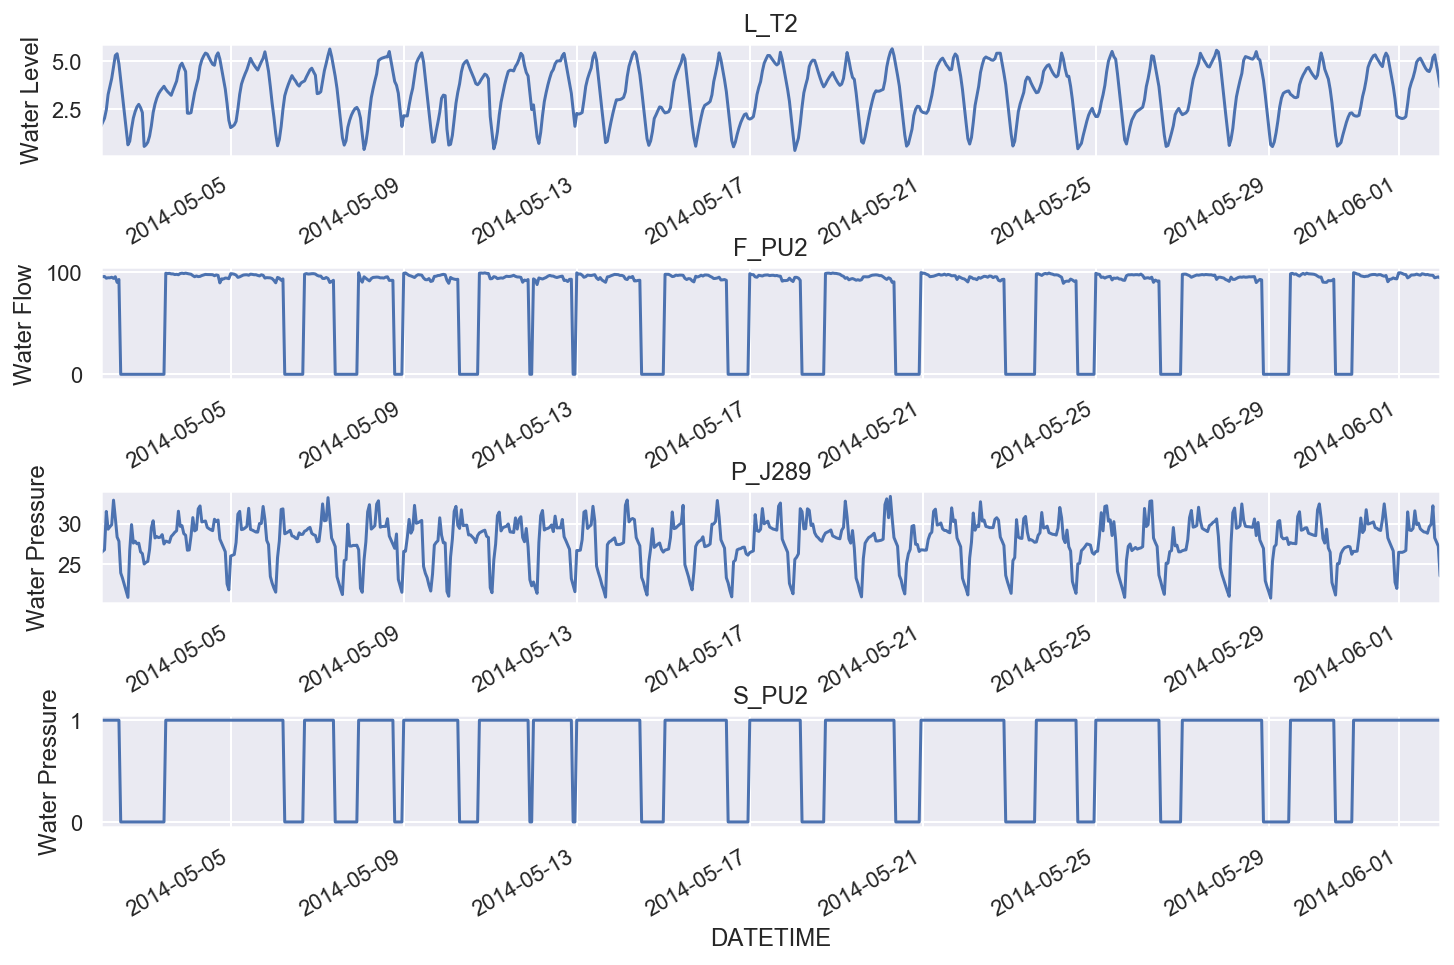

In [3]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize =(12, 8))
data.loc['2014-05-01':'2014-06-01', 'L_T2'].plot(linestyle='-', ax=ax1)
ax1.set_ylabel('Water Level')
ax1.set_title("L_T2")
ax1.set_xlabel('')
data.loc['2014-05-01':'2014-06-01', "F_PU2"].plot(linestyle='-',ax=ax2)
ax2.set_ylabel('Water Flow')
ax2.set_title("F_PU2")
ax2.set_xlabel('')
data.loc['2014-05-01':'2014-06-01', 'P_J289'].plot(linestyle='-',ax=ax3)
ax3.set_ylabel('Water Pressure')
ax3.set_title('P_J289')
ax3.set_xlabel('')
data.loc['2014-05-01':'2014-06-01', 'S_PU2'].plot(linestyle='-',ax=ax4)
ax4.set_ylabel('Water Pressure')
ax4.set_title('S_PU2')
plt.subplots_adjust(hspace=1)
plt.show()

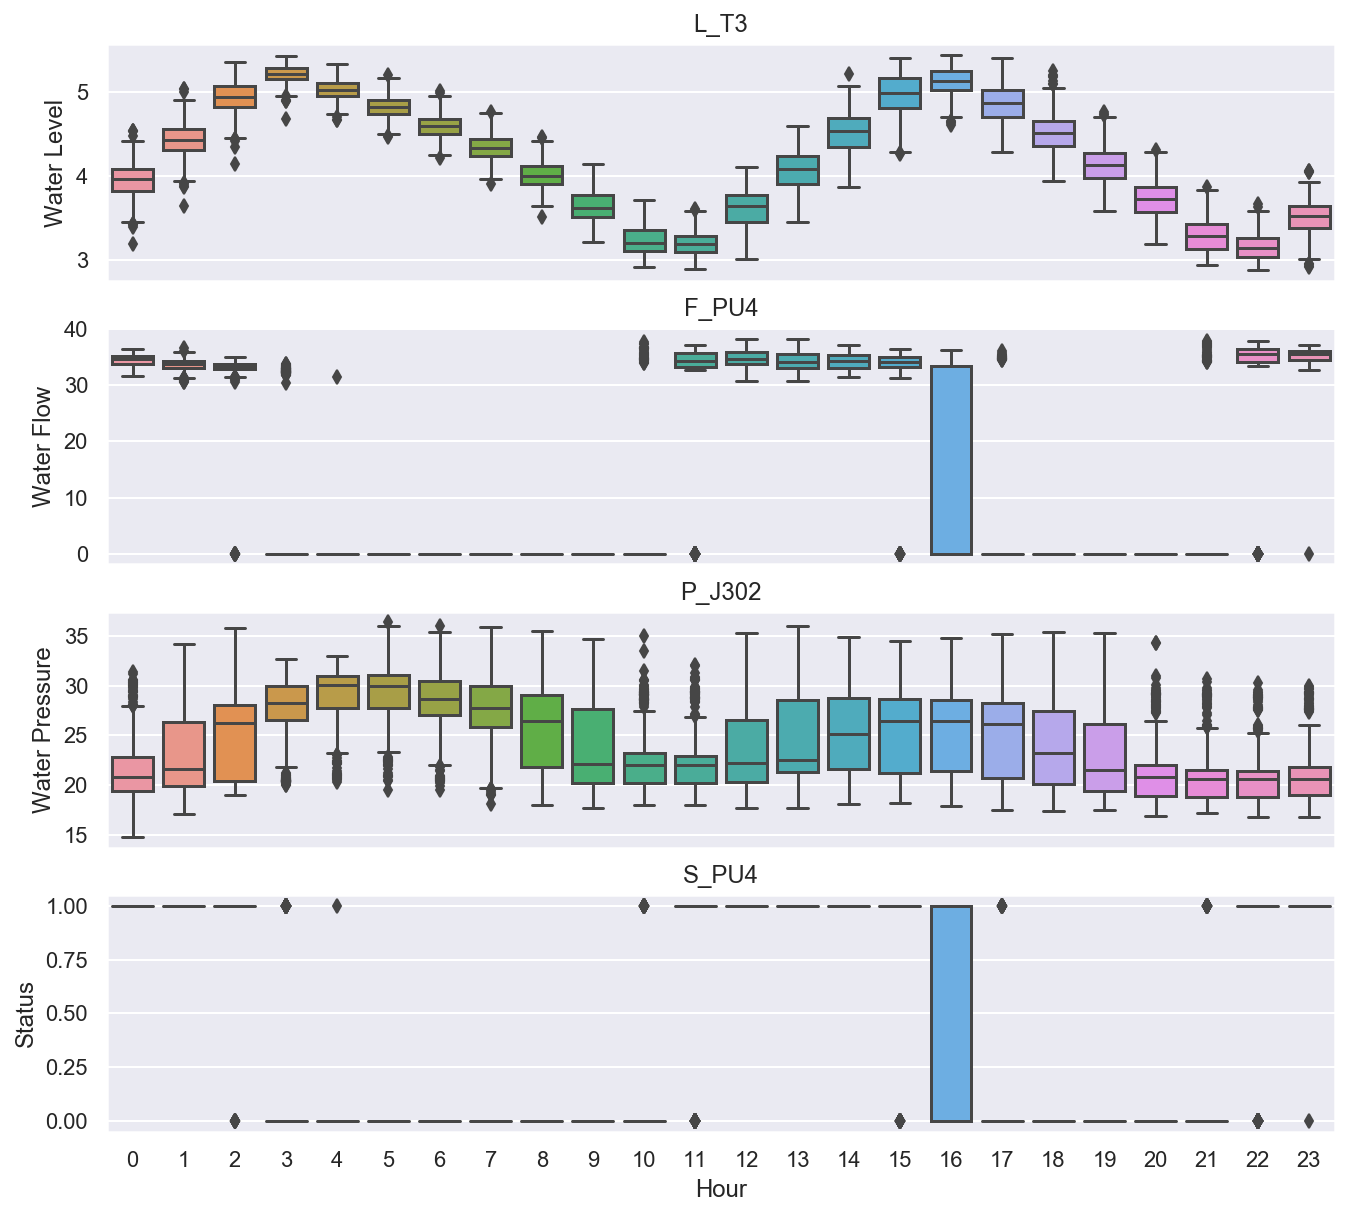

In [4]:
fig, axes = plt.subplots(4, 1, figsize=(11, 10), sharex=True)
for yaxis,name, ax in zip(["Water Level","Water Flow","Water Pressure","Status"],['L_T3', 'F_PU4', 'P_J302',"S_PU4"], axes):
    sns.boxplot(data=data, x='Hour', y=name, ax=ax)
    ax.set_ylabel(yaxis)
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

### 1b-I) What type of signals are there ?

#### Here we see we have 4 main types of signals in the dataset. They are-:
* Water Levels associated with the water tankers denoted by "L_TankID". (7 variables)
* Inlet and outlet pressure associated with the actuated valves and pumping stations denoted as "P_JunctionID". (12 variables).
* Flow through the actuated valves and pumps denoted using "F_actuatorID" (12 Variables)
* Status of the actuated valves and pumps denoted by "S_actuatorID". (12 Variables)

### 1b-II) Are the signals correlated, do they show cyclic behaviour ?

1) Firstly based on the above visualization which shows the 4 different signals discussed in the previous question, we do see signs of correlation. More specifically, we see that the flow of water through pump 2 is positively correlated with the status. Moreover, we can also start to see similar temporal patterns for the water level at tank 2 and the pressure at junction 289. ( More generally, we find that the flow and status of actuated valves and pumps are always positively correlated. )

2) We can also spot cyclic behaviour for some of the signals. If we look at the box plots made for the different signals with respect to their hourly values, we can clearly see a cyclic pattern especially for water levels for tank 3 (L_T3).

In [5]:
# Significant correlation between water level at tank 2 and pressure at P_J289 as well between flow and status at pump 2. 
(np.corrcoef(data["L_T2"],data["P_J289"])[1][0],np.corrcoef(data["F_PU2"],data["S_PU2"])[1][0])

(0.5947713172315865, 0.9986139581288066)

### 1b-III) Is predicting the next value in a series easy or hard?

Note- Here we use a sliding window approach to predict the next value of a series. The dataset is created by choosing a signal i.e L_T1 in our case and using a sliding window of 23 timesteps. Therefore 23 values preceeding the 24th value of the series is considered to be the features with the 24th value being the associated label for our dataset. We then train a random forest regressor model on the first training dataset and use a randomized grid search to find the best paramaters for the model based on the second training dataset. We finally generate predictions using the best parameters we found through the validation set and use those for the test set. We conclude with our findings. 

In [6]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 55, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [8]:
# Using a 24 hour sliding window approach to create train, val and test sets. 
LT1=data["L_T1"].values[1:]
TrainingData = pd.DataFrame(LT1.reshape(365,24))
X = TrainingData.iloc[:,:22]
Y = TrainingData.iloc[:,23]
ValidationData=dataA["L_T1"].values[1:]
ValidationData = pd.DataFrame(ValidationData.reshape(174,24))
X_val = ValidationData.iloc[:,:22]
Y_val = ValidationData.iloc[:,23]
test_LT1=testdata["L_T1"].values[1:]
testData = pd.DataFrame(test_LT1.reshape(87,24))
X_test = testData.iloc[:,:22]
Y_test = testData.iloc[:,23]

In [9]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model 
y_pred = rf_random.fit(X, Y).predict(X_val)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.5s finished


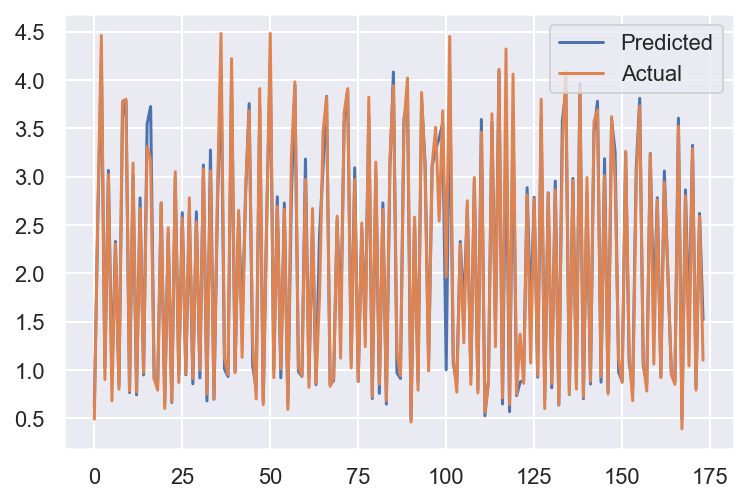

In [10]:
plt.plot(y_pred,label="Predicted")
plt.plot(Y_val,label="Actual")
plt.legend()
plt.show()

In [11]:
mean_squared_error(Y_val,y_pred)

0.03978463069921393

In [12]:
rf_random.best_params_

{'n_estimators': 30,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': True}

In [13]:
#Fitting best parameters for test set. 
rf = RandomForestRegressor(n_estimators=40,min_samples_split=2,min_samples_leaf=1,max_features="auto",max_depth=None,bootstrap=True)
y_pred_test = rf.fit(X, Y).predict(X_test)

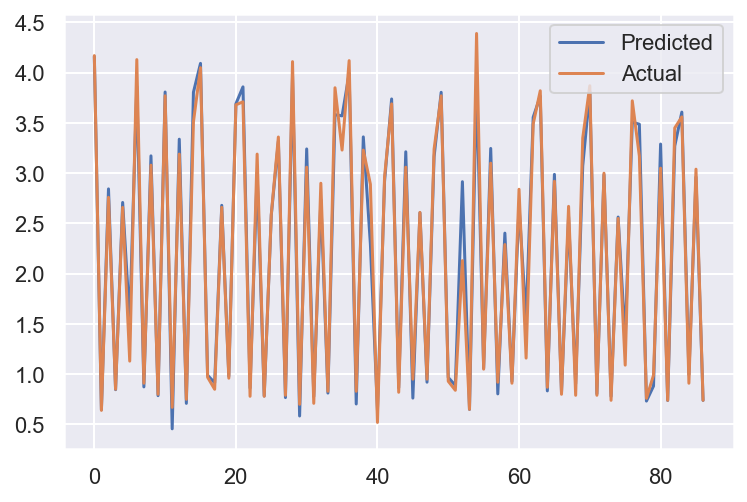

In [14]:
plt.plot(y_pred_test,label="Predicted")
plt.plot(Y_test,label="Actual")
plt.legend()
plt.show()

In [15]:
mean_squared_error(Y_test,y_pred_test)

0.031968047285319316

Therefore based on the plots and the mean squared error which was quite low as well, we can say predicting the next value in the water levels for tank 1 i.e L_T1 is relatively straightforward. 

## 2. LOF task – 1/2 A4 – Individual

### 2a. Plot LOF scores

In [16]:
# Helper Functions for LOF Task

# Function to calculate Euclidean distance given two points
def euclideanDistance(row1, row2):
    distance = 0.0
    for i in range(len(row1)):
        distance = distance + (row1[i] - row2[i])**2
    return math.sqrt(distance)

# Function to calculate k-nearest neighbours as a list, given a point.
def k_neighbors(curr_row, data, k):
    i = 0
    dist_list = list()
    for idx in range(len(data)):
        dist = euclideanDistance(curr_row, data[idx])
        dist_list.append((idx, dist))
        
    dist_list.sort(key=lambda tup: tup[1])
    k_neighbours = list()
    
#   k+1 as the closest neighbour is the point itself
    for i in range(k+1):
        k_neighbours.append(dist_list[i][0])
        
    return k_neighbours[1:]

# Function to calculate the 'reach_distance'
def reach_dist(row1, row2, k_distance):
    return max(euclideanDistance(row1, row2), k_distance)

In [17]:
def LOF(data, k=2):
    k_distance = np.zeros(len(data))
    
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(data)
    distances, knn_list = nbrs.kneighbors(data)

    for i in range(len(data)):
        k_distance[i] = euclideanDistance(data[i], data[int(knn_list[i][k])])

    lrd = np.zeros(len(data))
    for i in range(len(data)):
        sum_reach_dist = 0
        nn_list = knn_list[i][1:]
        for j in range(len(nn_list)):
            sum_reach_dist = sum_reach_dist + reach_dist(data[i], data[int(nn_list[j])], k_distance[int(nn_list[j])])
        lrd[i] =  len(nn_list)/sum_reach_dist
    lof = np.zeros(len(data))

    for i in range(len(data)):
        nn_list = knn_list[i][1:]
        sum_lrd = 0
        sum_rd = 0
        for j in range(len(nn_list)):
            sum_lrd = sum_lrd + lrd[int(nn_list[j])]
            sum_rd = sum_rd + reach_dist(data[i], data[int(nn_list[j])], k_distance[int(nn_list[j])])
        lof[i] = (sum_lrd*sum_rd)/(len(nn_list)*len(nn_list))
    return lof

In [ ]:
nn_array = [2, 10, 50, 100, 150, 200, 300]

lof_df = data.drop(['ATT_FLAG', 'Year',
       'Month', 'Weekday Name', 'Hour'], axis=1)
lof_df_validation = dataA.drop(['ATT_FLAG'], axis=1)

lof_mat = np.zeros((len(nn_array),len(data)))
lof_mat_validation = np.zeros((len(nn_array),len(dataA)))

for idx, z in enumerate(nn_array):
    lof_mat[idx] = LOF(lof_df.values, z)
    lof_mat_validation[idx] = LOF(lof_df_validation.values, z)

avg_lof = np.zeros(len(nn_array))
avg_lof_validation = np.zeros(len(nn_array))
for index in range(len(nn_array)):
    avg_lof[index] = np.mean(lof_mat[index])
    avg_lof_validation[index] = np.mean(lof_mat_validation[index])

In [ ]:
fig = plt.figure(figsize=(7,4))
fig.suptitle('Avg. LOF_scores with different nearest neighbours')
plt.xlabel('Nearest neighbours')
plt.ylabel('LOF Score')
plt.plot(nn_array, avg_lof)
plt.plot(nn_array, avg_lof_validation)

In [ ]:
dflof = pd.DataFrame(lof_mat_validation[3])
lof_predictions = dflof[0].apply(lambda x: 1 if x > 2 else 0).values

In [ ]:
cm = confusion_matrix(dataA['ATT_FLAG'].values, lof_predictions)
akws = {"ha": 'center',"va": 'center'}
fig = plt.figure(figsize=(4,3))
fig = plt.plot(figsize=(7,3))
ax = sns.heatmap(cm, annot=True, fmt="d", annot_kws=akws)

# # labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
# ax.set_title('Confusion Matrix-UnSmoted NB')
ax.xaxis.set_ticklabels(['Normal', 'Anomaly']); ax.yaxis.set_ticklabels(['Normal', 'Anomaly'])

### 2b. Analysis and answers to the questions

## 3. PCA task – 1/2 A4 – Individual

Note- The steps performed to detect anomalies using the PCA approach are described here :-

1) I remove irrelevant columns created previously for visualization purposes and mean centre the data before applying PCA.

2) I apply PCA and visualize the explained variance ratio of the principle components.

3) I then plot projections of the first training dataset i.e Training Data 1 on the different components.

4) Based on the paper titled "Diagnosing Network-Wide Traffic Anomalies", I similarly use a heuristic which is used to select the optimal number of components to be assigned to the normal and anomolous subspaces for training data 1.

5) I then project the data points of training data 1 on the normal and anomolous subspaces.

6) I plot the squared norms or the SPE of the data points projected on the anomolous as well as the squared norms of data projected on the full space (anomalous+normal).

7) In order to calculate the threshold to identify anomalies, I use the same Q-statistic which was used in the paper titled "Diagnosing Network-Wide Traffic Anomalies."

8) As mentioned in the PCA assignment, I remove the abnormalities for training data 1 as we wish to extract normal behaviour and repeat the steps 1-7 but now i transform training data 2 and the test data and similarly detect anomolies.

9) I present a confusion matrix for my results and conclude with the answers.

In [ ]:
# Dropping irrelevant columns before doing the PCA. 
df=data.drop(columns=[
    #'S_PU1', 'S_PU2', 'S_PU3', 'S_PU4',
    #   'S_PU5', 'S_PU6', 'S_PU7', 'S_PU8',
    #   'S_PU9', 'S_PU10','S_PU11','S_V2',
    'ATT_FLAG','Year',
       'Month', 'Weekday Name', 'Hour'])


dfA=dataA.drop(columns=[
    #'S_PU1', 'S_PU2', 'S_PU3', 'S_PU4',
    #   'S_PU5', 'S_PU6', 'S_PU7', 'S_PU8',
    #   'S_PU9', 'S_PU10','S_PU11','S_V2',
    ' ATT_FLAG'])

In [ ]:
# Mean centering the datasets before applying PCA.
df=df-df.mean(axis=0)
dfA=dfA-dfA.mean(axis=0)

In [ ]:
# Generating projection of the data using PCA.
pca = PCA(n_components=df.shape[1])
pca.fit(df)
principalProjections = pca.transform(df)
for i in range(df.shape[1]):
    principalProjections[:,i]=principalProjections[:,i]/np.linalg.norm(principalProjections[:,i])

In [ ]:
dff=pd.DataFrame(columns=["a","b"])
dff["No of Components"] = list(np.arange(1,11))#pca.explained_variance_.shape[0])
dff["Explained Variance Ratio"]=pca.explained_variance_ratio_.ravel()[:10]
sns.set(rc={'figure.figsize':(10, 3)})
sns.lineplot(y="Explained Variance Ratio", x="No of Components", data=dff)
plt.show()

This graph shows us that a few principle components capture the most amount of variance in the data meaning that the data can be effectively encapsulated in a lower dimensional space.

In [ ]:
# Plotting a signal(L_T1) from the first training dataset projected on the different principle components.
pCdf = pd.DataFrame(principalProjections,columns=df.columns,index=df.index)

f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize =(12, 8))

pCdf.loc['2014-05-01':'2014-06-01', df.columns[0]].plot(linestyle='-',ax=ax1)
ax1.set_ylabel("Water level")
ax1.set_xlabel("")
ax1.set_title("1st component")
pCdf.loc['2014-05-01':'2014-06-01', df.columns[1]].plot(linestyle='-',ax=ax2)
ax2.set_ylabel("Water level")
ax2.set_xlabel("")
ax2.set_title("2nd component")
pCdf.loc['2014-05-01':'2014-06-01', df.columns[9]].plot(linestyle='-',ax=ax3)
ax3.set_ylabel("Water level")
ax3.set_xlabel("")
ax3.set_title("10th component")
pCdf.loc['2014-05-01':'2014-06-01', df.columns[10]].plot(linestyle='-',ax=ax4)
ax4.set_ylabel("Water level")
ax4.set_title("11th component")
plt.subplots_adjust(hspace=1)
plt.show()

Based on these plots we can see that there is a clear difference between the normal and anomolous projections. The data represented through the 1st and 2nd principle components show more deterministic and cyclic behaviour as compared to the 10th and 11th components which are largely homogenous but contain anomalous spikes.  

In [ ]:
#Selecting the number of normal components based on std heuristic as was done in the paper "Diagnosing network-wide traffic anomalies". 
std=principalProjections.std(axis=0)
out=[]
for i in range(principalProjections.shape[1]):
    for x in principalProjections[:,i]:
        if x>3*std[i]:
            out.append(i)
(out[0])#All subsequent principle components belong to the anomalous space.            

In [ ]:
# Storing components derived by PCA on the first training dataset.
comp = pca.components_
#Creating C and C_ which project each data point in our dataset onto normal and anomalous spaces respectively. 
P=comp.T[:,:4]
C = np.dot(P,P.T)
C_=(np.eye(C.shape[0],C.shape[1])-C)

In [ ]:
#Each row from the first training dataset will now be converted to it's respective normal and anomolous space.
y_hat = np.dot(C,df.values.T).T #normal space
y_bar = np.dot(C_,df.values.T).T #anamolous space
y=y_bar+y_hat

In [ ]:
# Calculating squared norms of Y and Y_anamolous. 
square_normsY= [np.linalg.norm(x)**2 for x in y]
square_normsY_Anomaly = [np.linalg.norm(x)**2 for x in y_bar]

### 3a. Plot PCA residuals

In [ ]:
# Plotting the squared norms of Y = Y_normal + Y_anomalous
plt.plot(square_normsY[:1000])
plt.xlabel("Index")
plt.ylabel("Squared Norm Values")
plt.show()

In [ ]:
# Plotting the squared norms of Y_anomalous
plt.plot(square_normsY_Anomaly[:1000])
plt.xlabel("Index")
plt.ylabel("Squared Norm Values")
plt.show()

Here again similar to the visualisations made previously, we see that the squared prediction error (SPE) or the squared norms of the data points projected on the anomolous space contains suspicious spikes which are not present in the squared norm of the data points projected on the full space(normal+anomalous).

In [ ]:
# Creating threshold to detect anomolous behaviour as was done in the paper titled "Diagnosing Network-Wide Traffic Anomalies.".
alpha1=pca.explained_variance_[4:].sum()
alpha2=((pca.explained_variance_[4:])**2).sum()
alpha3=((pca.explained_variance_[4:])**3).sum()
h0= 1- (2*alpha1*alpha3)/(3*alpha2**2)
Thresh = alpha1*((.999*(2*alpha2*h0**2)**(1/2)/alpha1) + 1 + (alpha2*h0*(h0-1))/alpha2**2)**(1/h0)

In [ ]:
Thresh

In [ ]:
#Booly used to store the indices which correspond to anomolous behaviour in the first training dataset. 
booly = []
for i in y_bar:
    if np.linalg.norm(i)**2>=Thresh:
        booly.append(1)
    else:
        booly.append(0) 

In [ ]:
#Ridding the first training dataset of the anomolous points discovered using PCA as we want to extract the most normal behaviour
dropindex=[]
for i in range(len(booly)):
    if booly[i]>0:
        dropindex.append(i) 
index=list(set(range(len(booly)))-set(dropindex))        
df=df.iloc[index]

In [ ]:
# Generating projection of the cleaned first training dataset using PCA and now transforming on training data 2. 
df=df-df.mean(axis=0)
dfA=dfA-dfA.mean(axis=0)
pca = PCA(n_components=dfA.shape[1])
pca.fit(df)
principalProjections = pca.transform(dfA)
for i in range(dfA.shape[1]):
    principalProjections[:,i]=principalProjections[:,i]/np.linalg.norm(principalProjections[:,i])

In [ ]:
#Selecting the normal components based on std heuristic as was done in the paper titled "Diagnosing Network-Wide Traffic Anomalies.".
std=principalProjections.std(axis=0)
out=[]
for i in range(principalProjections.shape[1]):
    for x in principalProjections[:,i]:
        if x>3*std[i]:
            out.append(i)
(out[0])#All subsequent principle components belong to the anomalous space.  

In [ ]:
comp = pca.components_
P=comp.T[:,:4]
C = np.dot(P,P.T)
C_=(np.eye(C.shape[0],C.shape[1])-C)

In [ ]:
#Each row from the first training dataset will now be converted to it's respective normal and anomolous space.
y_hatA = np.dot(C,dfA.values.T).T #normal space
y_barA = np.dot(C_,dfA.values.T).T #anamolous space

In [ ]:
#Residuals of the second training dataset.
square_normsYA= [np.linalg.norm(x)**2 for x in y_barA]
plt.plot(square_normsYA)

In [ ]:
# Creating threshold to detect anomolous behaviour as was done in "Diagnosing Network-Wide Traffic Anomalies".
alpha1=pca.explained_variance_[4:].sum()
alpha2=((pca.explained_variance_[4:])**2).sum()
alpha3=((pca.explained_variance_[4:])**3).sum()
h0= 1- (2*alpha1*alpha3)/(3*alpha2**2)
Thresh = alpha1*((.999*(2*alpha2*h0**2)**(1/2)/alpha1) + 1 + (alpha2*h0*(h0-1))/alpha2**2)**(1/h0)

In [ ]:
Thresh

In [ ]:
#BoolyA used to store the indices which correspond to anomolous behaviour in the second training dataset. 
boolyA = []
for i in range(y_barA.shape[0]):
    if np.linalg.norm(y_barA[i])**2>=Thresh:
        boolyA.append(i)

In [ ]:
#A holds the indices which are known attacks.
A=[]
for i in range(len(dataA[" ATT_FLAG"].values)):
    if dataA[" ATT_FLAG"].values[i]>0:
        A.append(i)

In [ ]:
#Number of samples in training set 2. Number of predicted attacks by PCA, number of known attacks.
(dfA.values.shape[0],len(boolyA),len(A))

In [ ]:
#Confusion Matrix to study performance= 
TP = len(A)-len(set(A)-set(boolyA))
FP = len(boolyA)-TP
FN = len(A)-TP
TN = (dfA.values.shape[0])- TP - FP - FN
TP,FP,FN,TN

In [ ]:
# Now doing the same for the test data.
testData = pd.read_csv("BATADAL_test_dataset.csv")
testData["DATETIME"] = pd.to_datetime(testData["DATETIME"])
testData = testData.set_index("DATETIME")

In [ ]:
#obtaining labels from the test dataset. Do not run this cell twice because of the drop command.
testDataLabels= testData["Labels"]
testData.drop(columns=["Labels"],inplace=True)
# Mean centering testData. 
testData = testData - testData.mean(axis=0)

In [ ]:
# Computing the projection matrices for anomalous and normal subspaces.  
comp = pca.components_
P=comp.T[:,:5] # Selected 5 as this gave the best results. 
C = np.dot(P,P.T)
C_=(np.eye(C.shape[0],C.shape[1])-C)

In [ ]:
#Each row from the test dataset will now be converted to it's respective normal and anomolous space.
y_hatT = np.dot(C,testData.values.T).T #normal space
y_barT = np.dot(C_,testData.values.T).T #anamolous space

In [ ]:
# Plotting the SPE for data points in the test dataset. 
square_normsYt= [np.linalg.norm(x)**2 for x in y_barT]
plt.plot(square_normsYt)

In [ ]:
#Box plot is used here to use a sensible threshold as the squared norms are out of porportion based on the Q statistic. 
B=plt.boxplot(square_normsYt)
[item.get_ydata()[1] for item in B['whiskers']]

In [ ]:
#BoolyT used to store the indices which correspond to anomolous behaviour in the test dataset. 
boolyT = []
for i in range(y_barT.shape[0]):
    if (np.linalg.norm(y_barT[i])**2>590.48) | (np.linalg.norm(y_barT[i])**2<14.11) :
        boolyT.append(i)
        

In [ ]:
#T holds the indices which are known attacks.
T=[]
for i in range(len(testDataLabels)):
    if testDataLabels[i]>0:
        T.append(i)

In [ ]:
#Number of samples in training set 2. Number of predicted attacks by PCA, number of known attacks.
(testData.values.shape[0],len(boolyT),len(T))

In [ ]:
#Confusion Matrix to study performance= 
TP = len(T)-len(set(T)-set(boolyT))
FP = len(boolyT)-TP
FN = len(T)-TP
TN = (testData.values.shape[0])- TP - FP - FN
TP,FP,FN,TN

### 3b-I) Why do we see anomolies in the residuals for training data 1?

This method works by capturing the significant temporal variations of our dataset in a lower dimension through the principal component analysis. Based on our plots, we find that the first few principle components capture the majority of the temporal variance and are an effective means of representing the normal subspace whereas the remaining principal components are useful in studying anomolous behaviour. This is because the bulk of the data which is normal will be mainly represented by the normal subspace however it will not be able to adequately account for the variance caused by the few anomalous data points and this is what is captured through the anomalous subspace. And this is why we can see these suspicious spikes in the residuals or the squared norms of the data points projected in the anomalous subspace. 

### 3b-II) What kind of anomalies can we detect using PCA?

By using a principal component analysis, we essentially arrive at components which point to the direction of maximum variance based on the kinds of correlations within our dataset. Therefore this approach helps identify those anamolies which do not correspond to regular correlations between attributes and lie in regions which are not pointing to the direction of maximum variance. Therefore these anomalous data points will not be well represented by the principal components which capture the most amount of variance and have a higher residual value indicating they are anomalous. This approach is well suited towards multi-variate data. 

## 4. ARMA task – 1/2 A4 - Individual

What kind of anomalies can you detect using ARMA models? Which sensors can be modeled effectively using ARMA?

### 4a. Print relevant plots and/or metrics to determine the parameters.

In [134]:
data = pd.read_csv("BATADAL_dataset03.csv")
dataA = pd.read_csv("BATADAL_dataset04.csv")
data["DATETIME"]= pd.to_datetime(data["DATETIME"])
dat = data.set_index('DATETIME')
dataA["DATETIME"]= pd.to_datetime(dataA["DATETIME"])
datA = dataA.set_index('DATETIME')
series=data["F_PU4"].values
seriesA = dataA[" F_PU4"].values

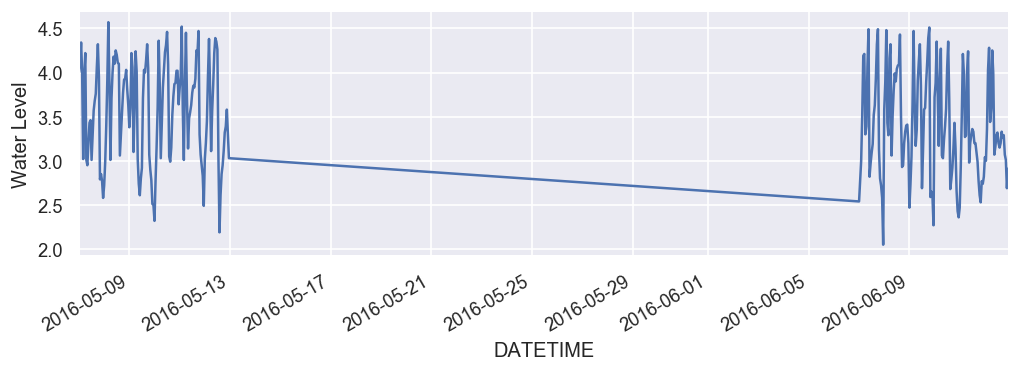

In [135]:
#Training Data 2 Signal
ax = datA.loc['2016-05-01':'2016-06-15', ' L_T4'].plot( linestyle='-',label="Daily")
ax.set_ylabel('Water Level');

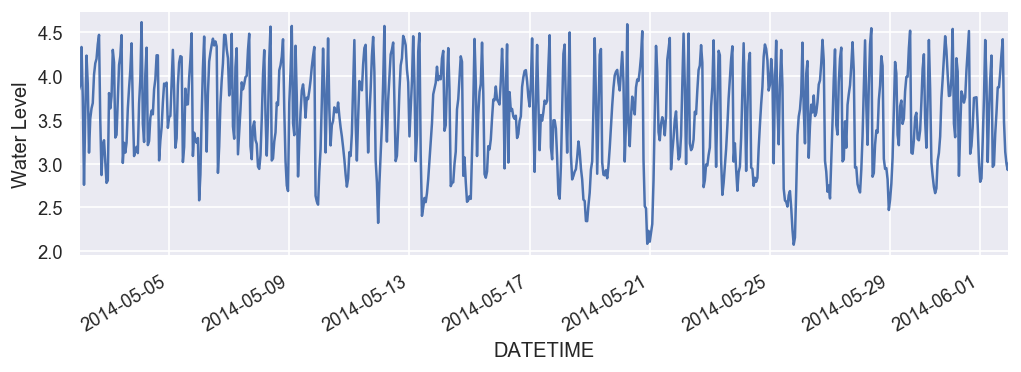

In [136]:
# Training data 1 signal. 
ax = dat.loc['2014-05-01':'2014-06-1', 'L_T4'].plot( linestyle='-',label="Daily")
ax.set_ylabel('Water Level');

In [137]:
# Differencing required if non stationary signals present in the first training dataset. It's stationary if p val >0.05.
for i in range((dat.shape[1])):
    print(dat.columns[i])
    result = adfuller(dat.iloc[:,i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])


L_T1
ADF Statistic: -20.615633
p-value: 0.000000
L_T2
ADF Statistic: -18.612726
p-value: 0.000000
L_T3
ADF Statistic: -14.375782
p-value: 0.000000
L_T4
ADF Statistic: -16.582866
p-value: 0.000000
L_T5
ADF Statistic: -18.509403
p-value: 0.000000
L_T6
ADF Statistic: -18.364822
p-value: 0.000000
L_T7
ADF Statistic: -17.489711
p-value: 0.000000
F_PU1
ADF Statistic: -27.596471
p-value: 0.000000
S_PU1


C:\Users\adity\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\adity\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\adity\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\adity\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\adity\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


ADF Statistic: nan
p-value: nan
F_PU2
ADF Statistic: -27.586431
p-value: 0.000000
S_PU2
ADF Statistic: -27.562711
p-value: 0.000000
F_PU3
ADF Statistic: nan
p-value: nan
S_PU3
ADF Statistic: nan
p-value: nan
F_PU4
ADF Statistic: -14.643662
p-value: 0.000000
S_PU4
ADF Statistic: -14.733583
p-value: 0.000000
F_PU5
ADF Statistic: nan
p-value: nan
S_PU5
ADF Statistic: nan
p-value: nan
F_PU6
ADF Statistic: -41.174938
p-value: 0.000000
S_PU6
ADF Statistic: -41.270903
p-value: 0.000000
F_PU7
ADF Statistic: -16.746262
p-value: 0.000000
S_PU7
ADF Statistic: -16.872092
p-value: 0.000000
F_PU8
ADF Statistic: -17.657014
p-value: 0.000000
S_PU8
ADF Statistic: -18.120287
p-value: 0.000000
F_PU9
ADF Statistic: nan
p-value: nan
S_PU9
ADF Statistic: nan
p-value: nan
F_PU10
ADF Statistic: -16.463434
p-value: 0.000000
S_PU10
ADF Statistic: -16.514121
p-value: 0.000000
F_PU11
ADF Statistic: -20.611544
p-value: 0.000000
S_PU11
ADF Statistic: -15.186888
p-value: 0.000000
F_V2
ADF Statistic: -23.325423
p-val

In [138]:
# Differencing required if non stationary in the second training dataset. It's stationary if p val >0.05. 
for i in range((datA.shape[1])):
    print(datA.columns[i])
    result = adfuller(datA.iloc[:,i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

 L_T1
ADF Statistic: -15.535737
p-value: 0.000000
 L_T2
ADF Statistic: -11.593365
p-value: 0.000000
 L_T3
ADF Statistic: -12.358874
p-value: 0.000000
 L_T4
ADF Statistic: -11.344067
p-value: 0.000000
 L_T5
ADF Statistic: -11.884362
p-value: 0.000000
 L_T6
ADF Statistic: -14.719612
p-value: 0.000000
 L_T7
ADF Statistic: -11.798303
p-value: 0.000000
 F_PU1
ADF Statistic: -19.256288
p-value: 0.000000
 S_PU1
ADF Statistic: nan
p-value: nan
 F_PU2
ADF Statistic: -20.035399
p-value: 0.000000
 S_PU2
ADF Statistic: -19.923801
p-value: 0.000000
 F_PU3
ADF Statistic: nan
p-value: nan
 S_PU3
ADF Statistic: nan
p-value: nan
 F_PU4
ADF Statistic: -10.565645
p-value: 0.000000
 S_PU4
ADF Statistic: -10.745166
p-value: 0.000000
 F_PU5
ADF Statistic: nan
p-value: nan
 S_PU5
ADF Statistic: nan
p-value: nan
 F_PU6
ADF Statistic: -5.526860
p-value: 0.000002
 S_PU6
ADF Statistic: -5.336197
p-value: 0.000005
 F_PU7
ADF Statistic: -5.303342
p-value: 0.000005
 S_PU7
ADF Statistic: -5.455861
p-value: 0.000003


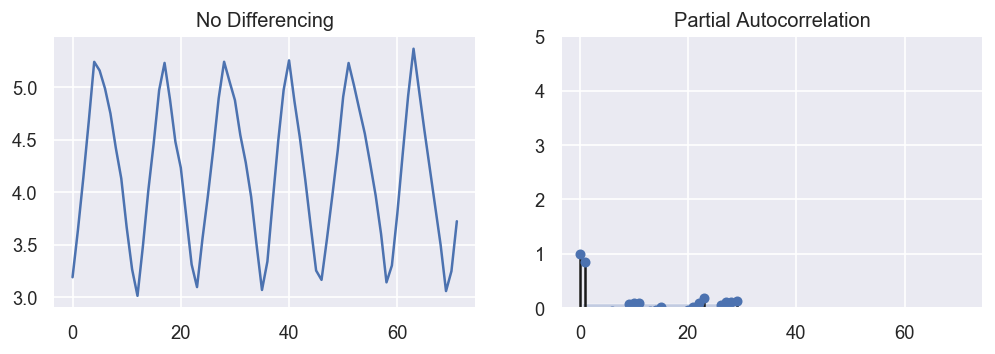

In [139]:
# PACF plot of series to get order for AR. 
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.L_T3[:72]); axes[0].set_title('No Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.L_T3[:720], ax=axes[1])

plt.show()

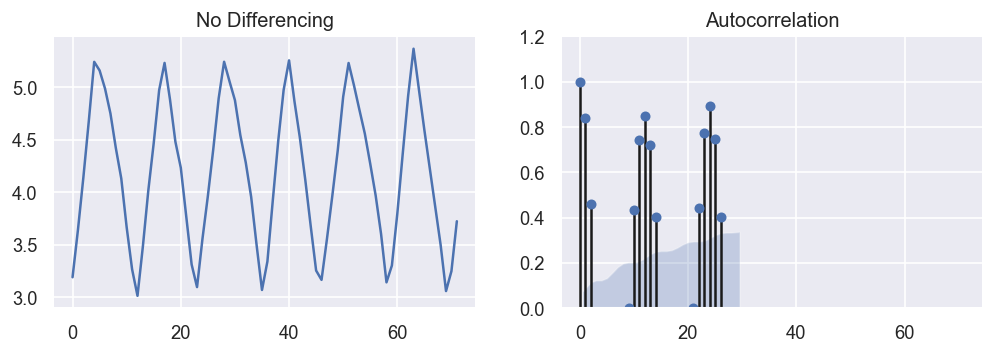

In [140]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.L_T3[:72]); axes[0].set_title('No Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data.L_T3[:720], ax=axes[1])

plt.show()

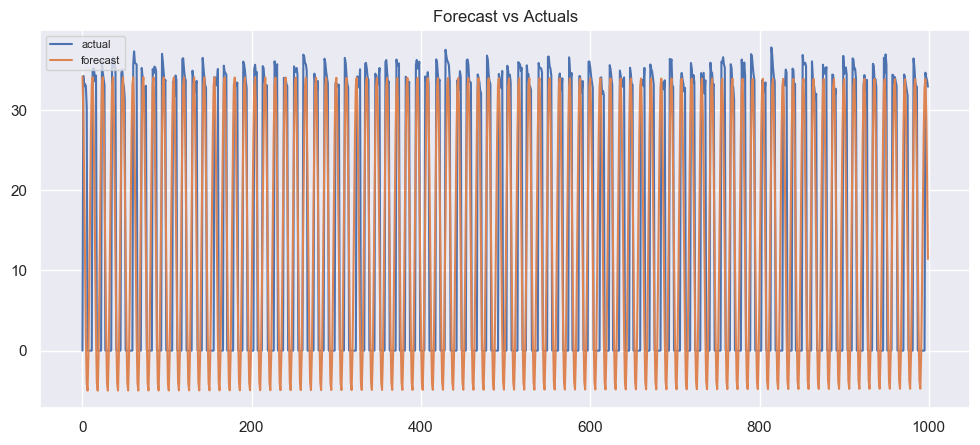

In [183]:
# Build Model
model = ARIMA(train, order=(2,0,3))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(test.shape[0], alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc[:1000], index=dataA.index[:1000])
#lower_series = pd.Series(conf[:, 0], index=dataA.index[:100])
#upper_series = pd.Series(conf[:, 1], index=dataA.index[:100])

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test[:1000], label='actual')
plt.plot(fc_series[:1000], label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
            #     color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [185]:
residuals=(fc-test)**2

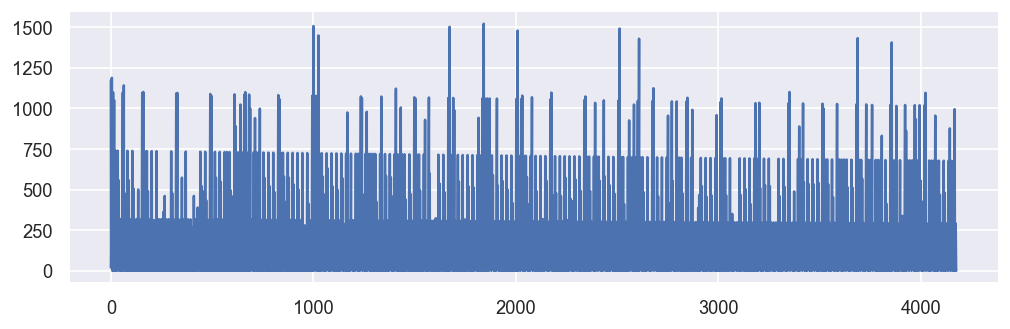

In [187]:
plt.plot(residuals)

In [194]:
anomoly_index=[]
for i in range(len(residuals)):
    if residuals[i]>700:
        anomoly_index.append(i)

In [195]:
len(anomoly_index)

243

In [196]:
len(set(A)-set(anomoly_index))

207

In [141]:
# Find the best order needed.

import pmdarima as pm


model = pm.auto_arima(series, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=7,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=69437.370, BIC=69465.682, Time=1.453 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=74553.248, BIC=74567.404, Time=0.126 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=69654.180, BIC=69675.414, Time=0.515 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=70749.393, BIC=70770.627, Time=1.370 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=79350.541, BIC=79357.619, Time=0.060 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=66519.523, BIC=66554.914, Time=6.111 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=69292.168, BIC=69320.480, Time=0.509 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=65975.238, BIC=66017.706, Time=7.168 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=68712.236, BIC=68747.626, Time=0.472 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=69288.745, BIC=69338.292, Time=5.534 seconds
Fit ARIMA(2,0,2)

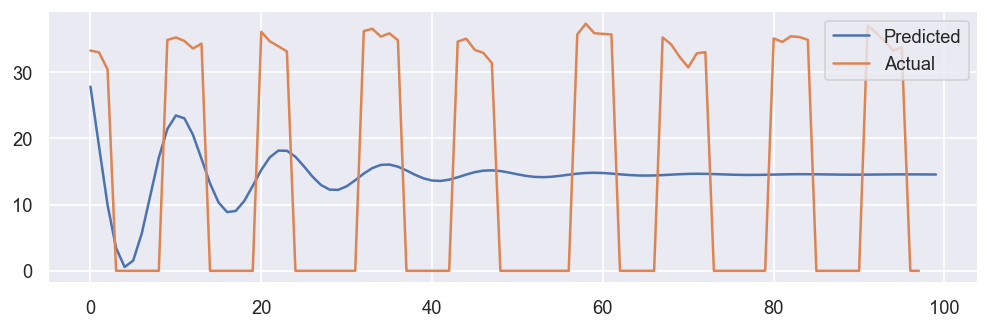

In [143]:
plt.plot(model.predict(100),label="Predicted")
plt.plot(seriesA[3:101],label="Actual")
plt.legend()
plt.show()

In [145]:
#The best parameters for my model. 
order=model.order

AttributeError: 'ARMA' object has no attribute 'order'

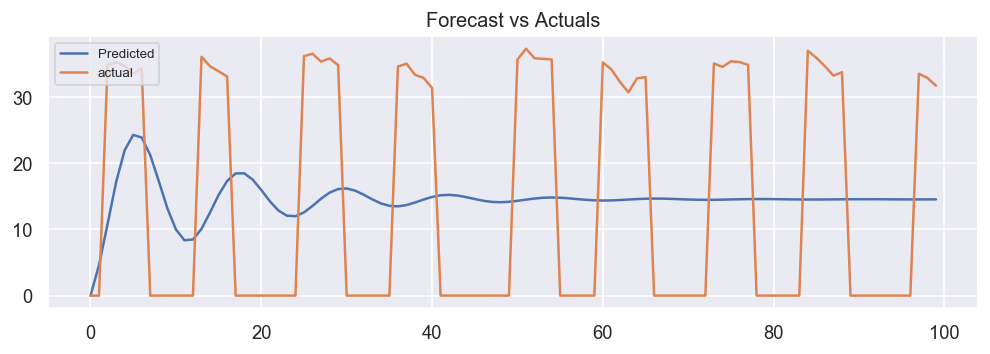

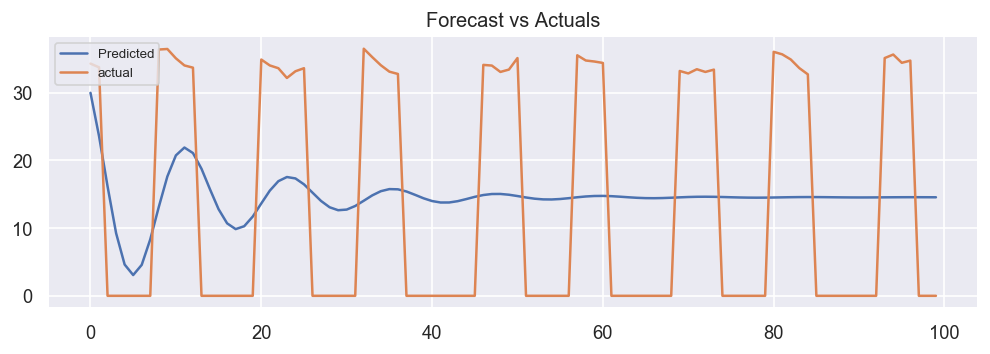

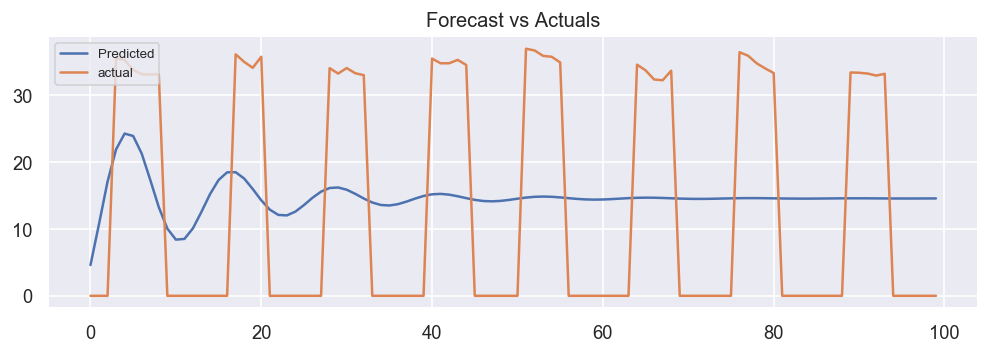

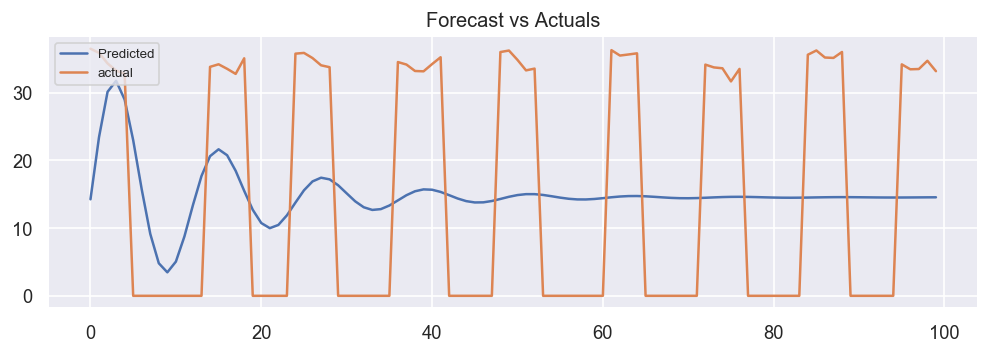

KeyboardInterrupt: 

In [179]:
train = series
errors=[]
test = seriesA
history = [x for x in train]
history.extend(test[:10])
predictions = list()
for t in range(10,len(test)-10,100):
    model = ARIMA(history, order=(3,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(100)
    #input(output[0].shape)
    yhat = output[0].ravel()
    predictions.append(yhat)
    obs = test[t:t+100]
    history.extend(obs)
    plt.figure()
    plt.plot(yhat,label='Predicted')
    plt.plot(obs,label='actual')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [147]:
len(predictions)

42

In [148]:
residuals=((np.array(predictions).ravel()[:4166]) - np.array(test[10:4176]))**2

### 4b. Plots to study the detected anomalies

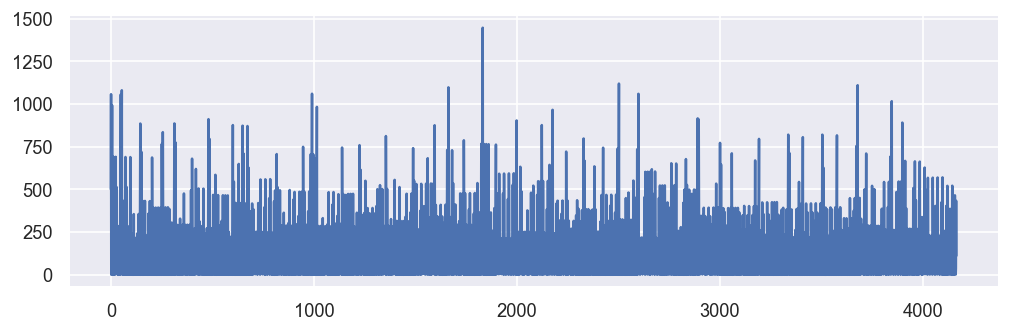

In [149]:
plt.plot(residuals)

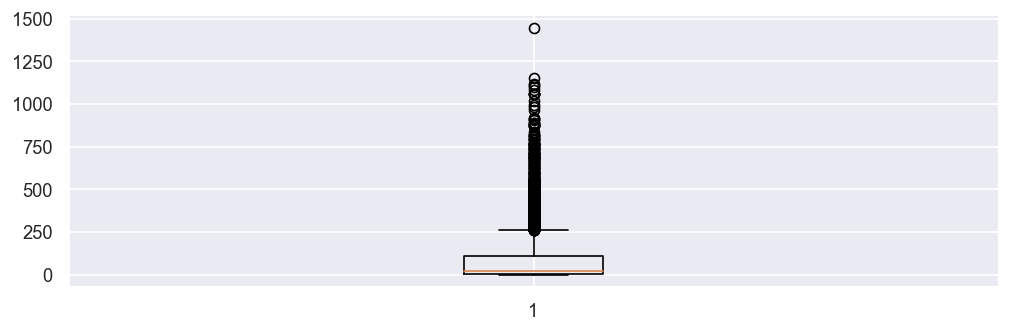

In [150]:
B=plt.boxplot(residuals)
limit=[item.get_ydata()[1] for item in B['whiskers']][1]

In [151]:
len(residuals)

4166

In [176]:
anomoly_index=[]
for i in range(len(residuals)):
    if residuals[i]>limit:
        anomoly_index.append(14+i)

In [177]:
len(anomoly_index)

573

In [178]:
len(set(A)-set(anomoly_index))

185

### 4c. Analysis and answers to the questions

## 5. N-gram task – 1/2 A4 - Individual

In [ ]:
def assign_sym(x, quantiles):
    for i in range(len(quantiles)):
        if x < quantiles.values[i]:
            return i
    return i+1

def discretize(col, p = 9): 
    quantiles = []
    quantiles = col.quantile(np.linspace(.1, 1, p, 0))
    percentiles = col.apply(lambda x: assign_sym(x, quantiles))
    return percentiles.values

def get_freq(ngram, data, ngram_map):
    gram_list = []
    for i in range(len(data)):
        if(len(data) - i > ngram-1):
            gram = ','.join(str(n) for n in data[i:i+ngram])
            count = ngram_map.get(gram)
            if count is not None:
                ngram_map[gram] = count + 1
    return list(ngram_map.values())

# discrete_counts

### 5a. Visualise discretization

In [ ]:
percentiles = discretize(data['L_T7'])
# fig = plt.plot(figsize=(7,3))
bars= ('group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7', 'group8', 'group9', 'group10')
plt.barh(np.arange(10), np.bincount(percentiles))
plt.yticks(np.arange(10), bars)

In [ ]:
def fill_labels(w_size, data):
    label = []
    for j in range(len(data)):
        if(len(data) - j > w_size-1):
            if np.sum(data[j:j+w_size]):
                label.append(1)
            else:
                label.append(0)
    return label

def ngrams(words, n):
    gram_list = []
    d = collections.deque(maxlen=n)
    d.extend(words[:n])
    words = words[n:]
    for window, word in zip(itertools.cycle((d,)), words):
        gram_list.append(','.join(window))
        d.append(word)
    return gram_list

def generate_ngram_map(data, ngram):
    ngram_array = []
    ngram_map = {}
    ngram_array = ngrams([str(f) for f in data], ngram)
    ngram_map = dict.fromkeys(ngram_array, 0)
    return ngram_map

def fill_table(w_size, ngram, data, ngram_map):
    table = []
#     Reset the counts
    ngram_map = ngram_map.fromkeys(ngram_map, 0)
    for j in range(len(data)):
        if(len(data) - j > w_size-1):
            table.append(get_freq(ngram, data[j:j+w_size], ngram_map))
    return table

In [ ]:
def detect_anomaly(test_df, train_df, y_train):
    labels = []
    sim_matrix = cosine_similarity(test_df, Y=train_df, dense_output=True)
    np.fill_diagonal(sim_matrix, -1)
    for i in range(len(test_df)):
        sim_row = sim_matrix[i]
        sim_idx = np.argmax(sim_row)
        if(y_train[sim_idx] == 1):
            labels.append(1)
        else:
            labels.append(0)
    return labels

def ngram_anomaly(train_df, test_df, w_size = 10, ngram = 3):
    att_labels = train_df['ATT_FLAG']
    train_df = train_df.drop(['ATT_FLAG'], axis =1)
    test_df = test_df.drop(['DATETIME'], axis =1)
    cosine_preds = pd.DataFrame(np.arange(len(test_df)-(w_size-1)), columns=['index'])
    for column in train_df:
        train_signal = train_df[column]
        percentiles = discretize(train_signal)

# Generate ngram map from the discretized data and len(ngram) in training set
        ngram_map = generate_ngram_map(data = percentiles, ngram = ngram)
# Generate table with window_index as rows and ngram freq as columns from training set
        ngram_table = fill_table(w_size, ngram, data = percentiles, ngram_map = ngram_map)
        ngram_df = pd.DataFrame(data = ngram_table)
        y_train = fill_labels(w_size, att_labels)
        print(len(y_train), ngram_df.shape)
        
# Generate table with window_index as rows and ngram freq as columns from test set
        test_signal = test_df[column]
        percentiles = discretize(test_signal)

        # Use the same n_gram map for testing
        ngram_table_test = fill_table(w_size, ngram, data = percentiles, ngram_map= ngram_map)
        ngram_df_test = pd.DataFrame(data=ngram_table_test)
        print(len(y_train), ngram_df_test.shape)
        y_preds = pd.DataFrame(detect_anomaly(ngram_df_test, ngram_df, y_train))
        cosine_preds[column] = pd.DataFrame(data= y_preds)

#     return pd.DataFrame(cosine_preds, columns=test_df.columns)
    return pd.DataFrame(cosine_preds)

In [ ]:
cosine_preds = ngram_anomaly(dataA, 
              test_df.drop(['att_preds'], axis=1))

In [ ]:
cosine_preds.drop(['index'], axis=1)

def unpack_windows(cosine_preds, w_size, threshold):
    df = pd.DataFrame(np.arange(len(test_df)), columns=['index'])
    window_map = dict.fromkeys(np.arange(len(test_df)), 0)
    for column in cosine_preds:
        y_preds = cosine_preds[column]
        for i in range(len(y_preds)):
            for j in range(i, i+w_size-1):
                freq = window_map.get(j)
                if y_preds[i]:
                    window_map[j] = freq + 1
        df[column] = pd.DataFrame(list(window_map.values()))
        df[column] = df[column].apply(lambda x: 1 if (x) > threshold else 0)
        
    return df.drop(['index'], axis=1)

In [ ]:
w_size = 10
predictions_df = unpack_windows(cosine_preds, w_size, threshold = w_size)

att_preds = []
for i in range(len(predictions_df)):
    att_preds.append(1 if np.sum(predictions_df.iloc[i].values) > 1 else 0)
    
test_df['att_preds'] = pd.DataFrame(att_preds)

In [ ]:
cm1 = confusion_matrix(y_test, test_df['att_preds'].values)
akws = {"ha": 'center',"va": 'center'}
fig = plt.figure( figsize=(4,3))
fig = plt.plot(figsize=(7,3))
ax = sns.heatmap(cm1, annot=True, fmt="d", annot_kws=akws)

# # labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
# ax.set_title('Confusion Matrix-UnSmoted NB')
ax.xaxis.set_ticklabels(['Normal', 'Anomaly']); ax.yaxis.set_ticklabels(['Normal', 'Anomaly'])

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Comparision task 1 A4 - Individual

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.

In [ ]:





### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

Dataset here : https://www.batadal.net/data.html You will need Training Dataset 1, Training Dataset 1 and Test Dataset.